In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Salary Prediction

This is a very basic dataset based on the paper from Ron Kohavi *"Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996*. The task is simple, just predict if someone is above or below 50k$.

Please check more on the original page where the data is downloaded from [here](https://www.openml.org/d/1590).

## Downloading data

In [2]:
import os
data_dir = '../data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

fname = data_dir+"/1_salary_prediction.csv"
if not os.path.exists(fname):
    !wget -O $fname "https://www.openml.org/data/get_csv/1595261/phpMawTba.csv"

## Importing modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#this is to set the style of our plots on seaborn
sns.set(style='ticks', context='notebook', palette='deep')
#sns.set_palette("BuGn_r")

## Data exploration

Here we'll try to understand a little bit of the dataset with some plots and basic analysis

In [4]:
df = pd.read_csv(fname)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
df.shape

(48842, 15)

There are 15 features and 48842 rows in our dataset. Let's see which of this features are categorical which ones numerical.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         48842 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    48842 non-null object
class             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


And a description for the numerical:

In [7]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [8]:
#Convert class to 0, 1. Be careful, use .string() to eliminate the space padding
df["class"] = df["class"].apply(lambda x: 0 if x.strip() == '<=50K' else 1)

Let's try to see how many classes do we have per each feature. That is for instance, how many countries are there in the *native-country* feature?

In [9]:
categorical_classes = ["workclass",
                 "education",
                 "marital-status",
                 "occupation",
                 "relationship",
                 "race",
                 "sex",
                 "native-country",
                 "class"]

tmp = df.copy() #create a separated copy from df
tmp = tmp.loc[:,categorical_classes] #subset cat classes
tmp = tmp.apply(lambda x: len(x.unique())) #count unique classes per feature

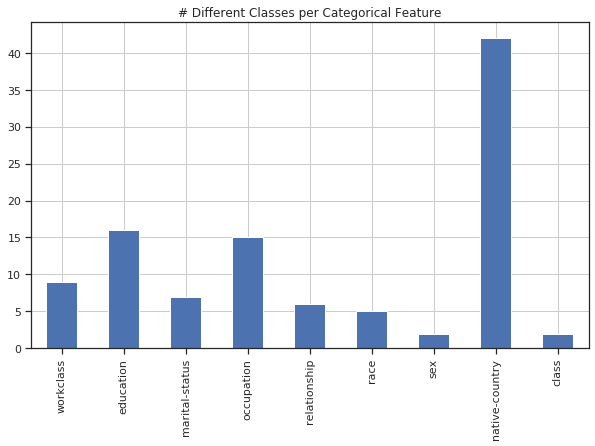

In [10]:
tmp.plot(kind = "bar",
         grid=True,
         title = "# Different Classes per Categorical Feature",
         figsize = (10,6))
plt.show()

We see there are many native countries very different ocupation and education. Let's see what are these values briefly.

<Figure size 432x288 with 0 Axes>

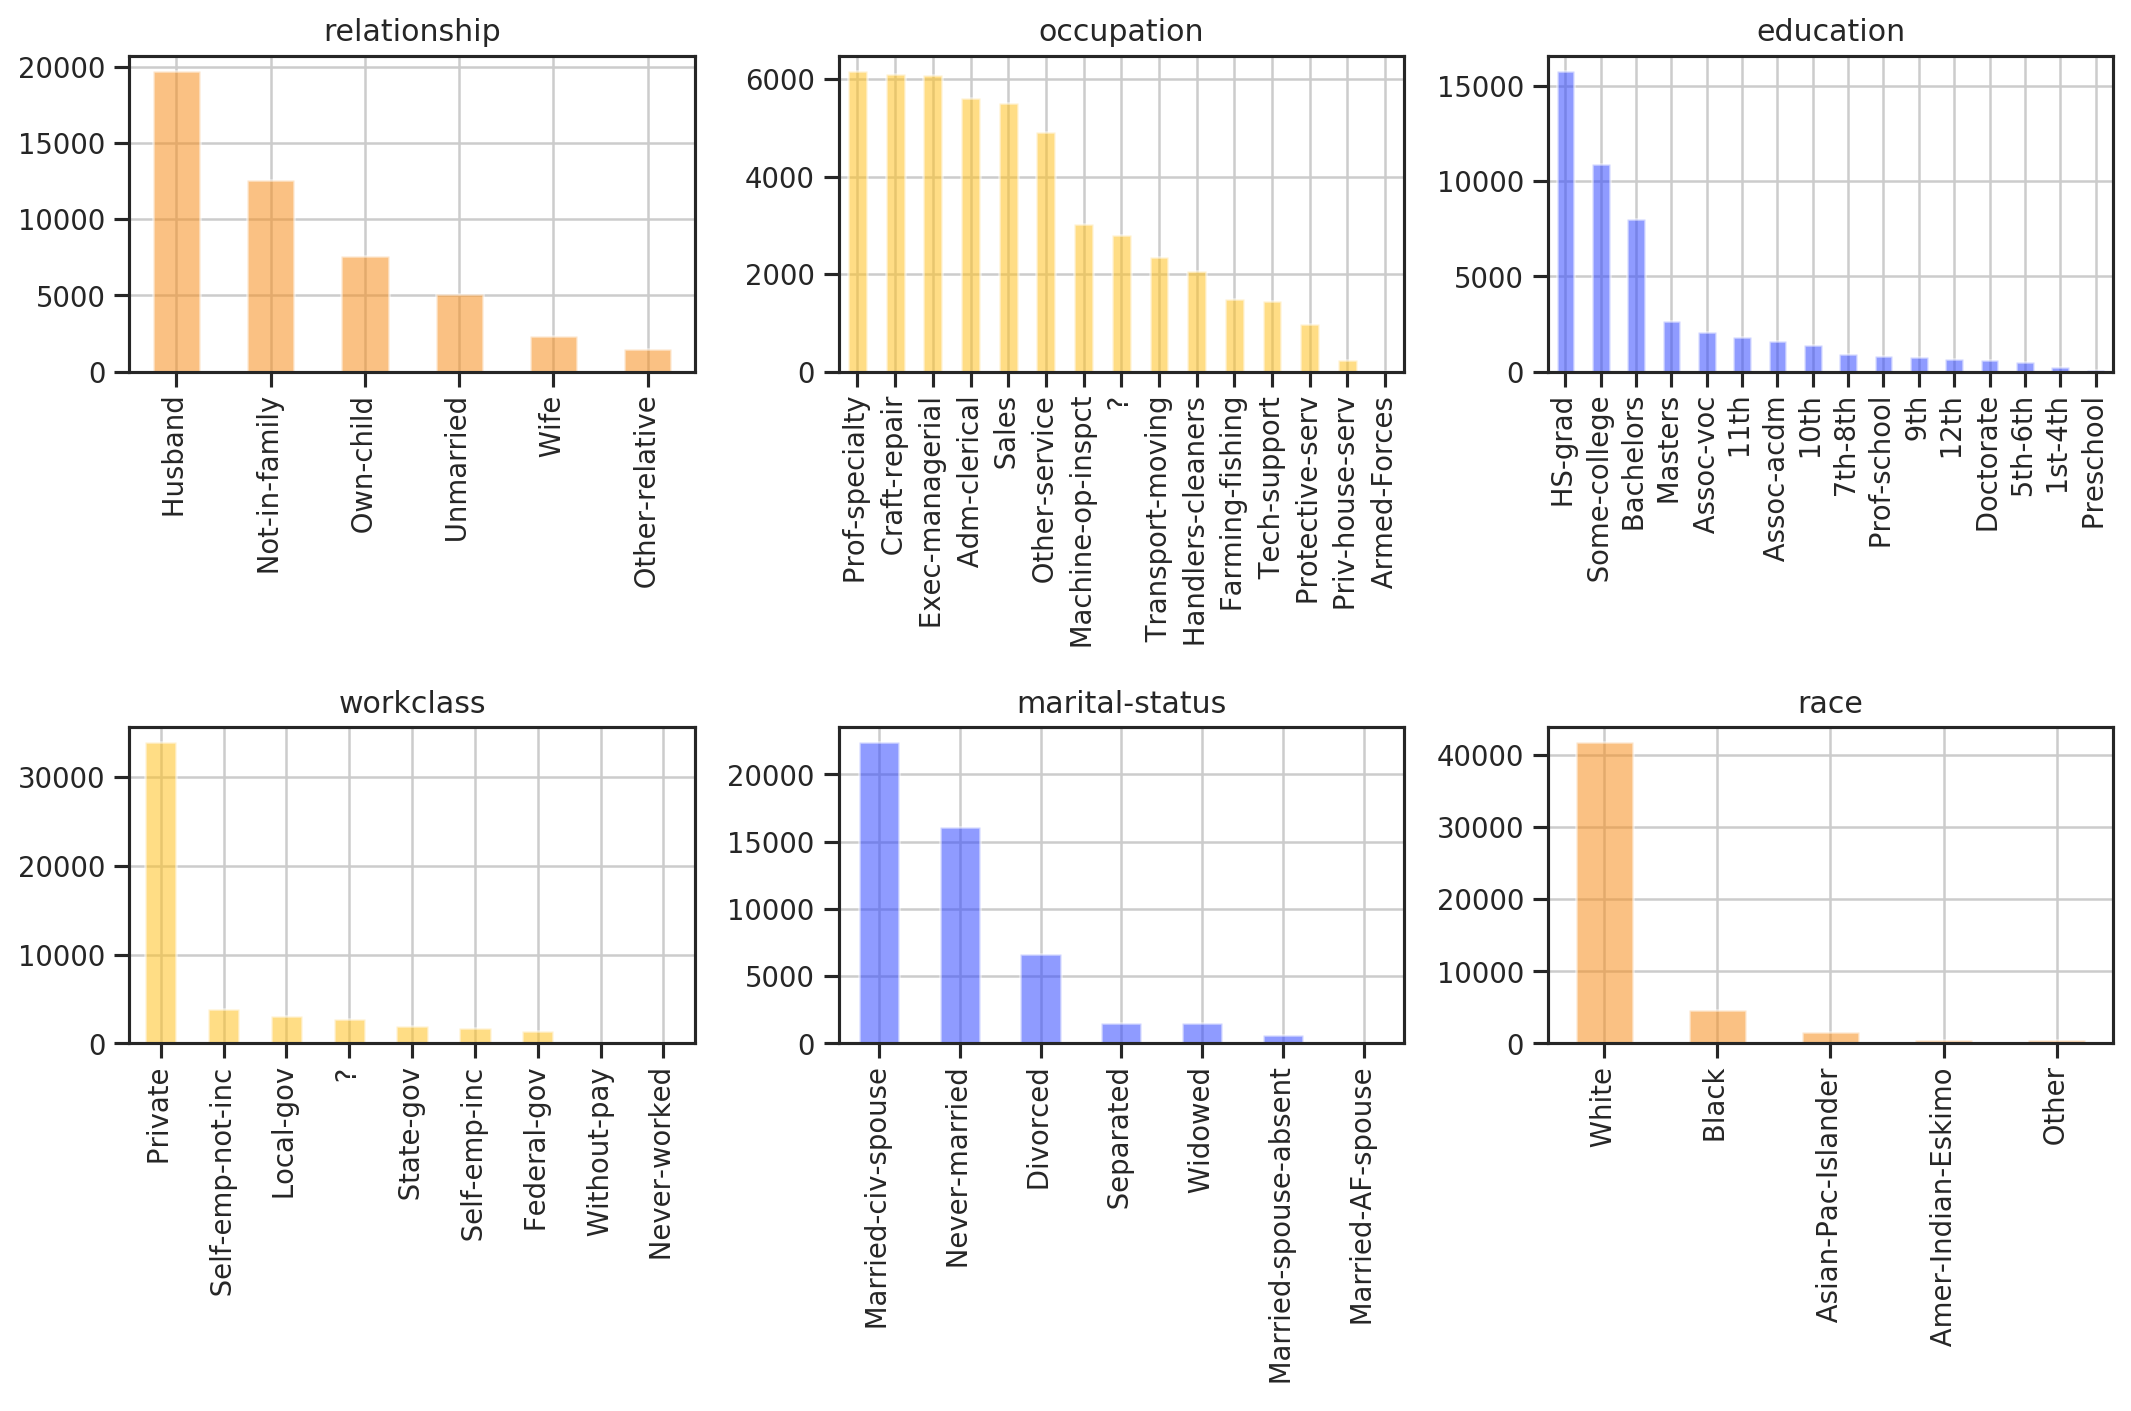

In [11]:
plt.clf()
def plot_hitograms(df,fields,colors,ncol,nrow):
    fig=plt.figure(dpi = 180, figsize=(12,8))
    for i,var_name in enumerate(fields):
        ax=fig.add_subplot(nrow,ncol,i+1)
        df[var_name].value_counts().plot(kind="bar",ax=ax,color =colors[i],alpha =0.55)
        ax.set_title(var_name)
        ax.grid()
    fig.tight_layout()  # Improves appearance a bit.
    
    plt.show()
    
plot_hitograms(df,fields = ["relationship","occupation","education","workclass","marital-status","race"],
               colors = ['#F78F1E','#FFC222','#3349FF','#FFC222','#3349FF','#F78F1E','#FFC222'],
               ncol = 3,
               nrow = 2)

In [12]:
df.loc[:,"sex"].value_counts().iloc[0:15]

 Male      32650
 Female    16192
Name: sex, dtype: int64

Interestingly most of the interviewees are husband or not in family, wifes are much less represented. It is weird that back in 1996 there was this huge sex balance but it is possible. Most of the people is professional and we have very few in the armed forces. As of education lots of high-school grads followed by people having attended college and bachelors. Not many people with PhD's!. Workclass, mostly people work in private this feature won't give us much information. There is a huge bias in race and sex, most of people is white and 2/3 of the population are male.

In [13]:
df.loc[:,"native-country"].value_counts().iloc[0:15]

 United-States    43832
 Mexico             951
 ?                  857
 Philippines        295
 Germany            206
 Puerto-Rico        184
 Canada             182
 El-Salvador        155
 India              151
 Cuba               138
 England            127
 China              122
 South              115
 Jamaica            106
 Italy              105
Name: native-country, dtype: int64

Most of our interviewees are from the US, this feature will tell us very few information. Let's now have a look on the numerical data

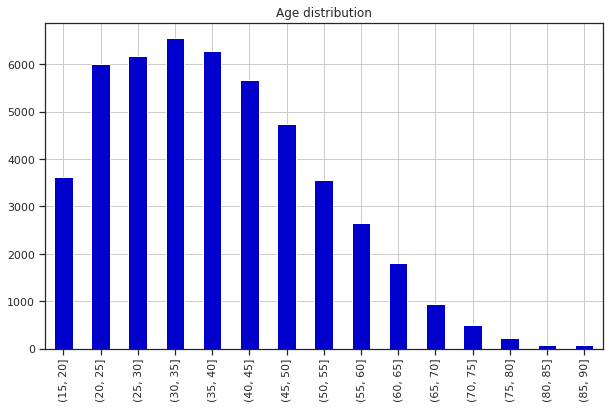

In [14]:
#first we create the bins, in our case partition the age from 0 to 125 in steps of 5
bins = list(range(15,95,5))
#then we name the bins, we can say the same but converting them to string
group_names = list(map(str,bins))
tmp = df.copy()
tmp['age_bin'] = pd.cut(tmp['age'], bins)

plt.clf()
plt.title("Age distribution")
tmp.age_bin.value_counts().sort_index().plot(kind = "bar",
                                             color = '#0000CD',
                                             figsize = (10,6),
                                             grid = True)
plt.show()

Age is interesting, most of the people lay in between 20 and 50, then the number of people starts to decrease. Could it be because early retirement?. Also what is this people above 70 working on? They could be outliers I suspect...

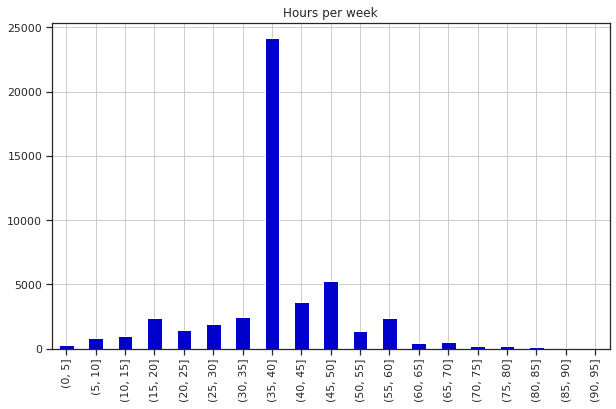

In [15]:
bins = list(range(0,100,5))
#then we name the bins, we can say the same but converting them to string
group_names = list(map(str,bins))
tmp = df.copy()
tmp['hours_per_week_bin'] = pd.cut(tmp['hours-per-week'], bins)

plt.clf()
plt.title("Hours per week")
tmp.hours_per_week_bin.value_counts().sort_index().plot(kind = "bar",
                                             color = '#0000CD',
                                             figsize = (10,6),
                                             grid = True)
plt.show()

This is more normal, most of the people lay in between 35 to 40 hours per week which is a regular 7-8 hours per day. Some people work even longer hours, we have peaks at 40-45 and 45-50. Then the numbers start do decrase (as it should be...). Those who work less may be part time jobs, maybe young students?.

<Figure size 432x288 with 0 Axes>

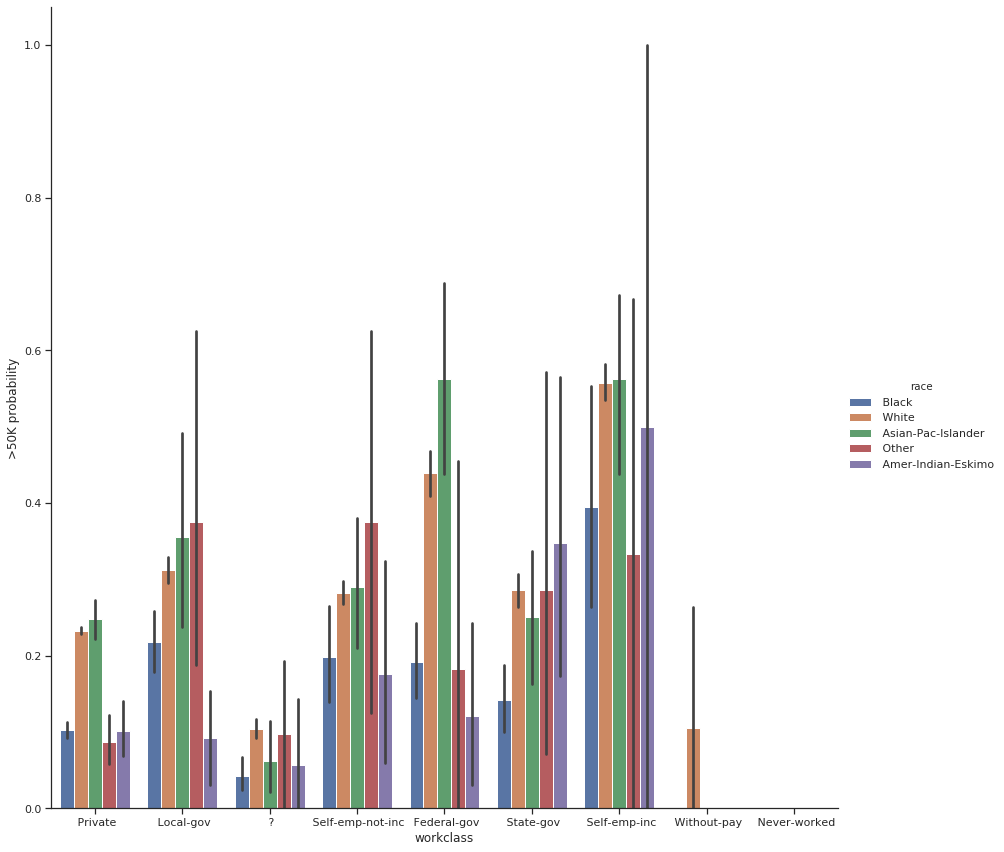

In [16]:
plt.clf()
g = sns.catplot(x="workclass", y="class", hue="race", data=df,height=12, kind="bar")
g = g.set_ylabels(">50K probability")
plt.show()

In [17]:
df['class'].mean()

0.23928176569346055

Data is quite unblanced... 24% is <50K whilst 76 is >=50K. This may cause problems on running ML models

## Machine Learning models

### Data preparation

In [18]:
#select numerical and categorical features.
numerical = [elem for elem in df._get_numeric_data().columns if elem not in ["class"]]
categorical = [feature for feature in list(df.columns) if feature not in numerical]

In [19]:
print("numerical values are: \n{}".format(numerical))
print("categorical values are: \n{}".format(categorical))

numerical values are: 
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical values are: 
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'class']


In [20]:
# for the initial model let's take less variables...
# This is a little bit arbiratry, why these variables and not others, just to show up a model here.
# Later on will show a feature selection method that can be applied here
numerical = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical = [ 'marital-status', 'relationship', 'race', 'sex']
target = ["class"]


In [21]:
df_ml = df.copy()
#one hot encode the part we need
encoded = pd.get_dummies(df_ml.loc[:,categorical])
df_ml = pd.concat([df_ml.loc[:,numerical],encoded],axis = 1)
df_ml.head()

,age,capital-gain,capital-loss,hours-per-week,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,25,0,0,40,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
1,38,0,0,50,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,28,0,0,40,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,44,7688,0,40,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,18,0,0,30,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,1,0


In [22]:
df_ml.shape

(48842, 24)

In [23]:
from sklearn.model_selection import train_test_split

#X will be the input of our model (the features) and y the predicted value
X = df_ml.copy()
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Logistic Regression 

Running a simple logistic regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc

logistic = LogisticRegression(random_state=10)
logistic.fit(X_train.values,y_train.values.reshape(-1))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=10, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Once the model is trained let's check the confusion matrix. First we predict on the test set and then apply the confusion matrix

In [25]:
#predict on test
y_predicted_logistic = logistic.predict(X_test.values)

conf = confusion_matrix(y_test,y_predicted_logistic)
conf

array([[11695,   621],
       [ 2448,  1354]])

In [26]:
print("Shape for test prediction == 1 is {}".format(y_test.loc[y_test["class"] == 1].shape))
print("Shape for test prediction == 0 is {}".format(y_test.loc[y_test["class"] == 0].shape))

Shape for test prediction == 1 is (3802, 1)
Shape for test prediction == 0 is (12316, 1)


So in my case (you may have a different random split and end up whith slightly different numbers) there are 12316 people on <50K of which 11695 are classified correctly (95%) whilst the rest (5%) is badly classified. On the people earning more than 50K there are only 3802 people of which 2448 (64%) are badly classified and just 1354 are correctly (36%) classified. 

Summing up, our model predicts very well if you are going to earn less than 50K but not so for >50K cases. Can be summed up more easily as:

In [27]:
#since this is binary case we can extract directly the tp, fp....
tn, fp, fn, tp = confusion_matrix(y_test,y_predicted_logistic).ravel()

print("tp: {} values are classified positive and are positive".format(tp))
print("tn: {} values are classified negative and are negative".format(tn))
print("fp: {} values predicted as positive but actually were negative".format(fp))
print("fn: {} values predicted as negative but actually were positive".format(fn))

tp: 1354 values are classified positive and are positive
tn: 11695 values are classified negative and are negative
fp: 621 values predicted as positive but actually were negative
fn: 2448 values predicted as negative but actually were positive


And finally the most popular metric... Acuracy

In [28]:
print("Accuracy is correctly_classified/total: {}".format(accuracy_score(y_test,y_predicted_logistic)))

Accuracy is correctly_classified/total: 0.8095917607643628


Another important measure is the area under the curve. The plot is generated by varying the threshold of classification using the scores.

True positive rate = well classified possitives / all positives
False positive rate = badly classified positives / all negatives

A nice explanation of ROC curve can be found [here](http://arogozhnikov.github.io/2015/10/05/roc-curve.html). Usually in a binary classification we classify 0 if score < 0.5 and 1 otherwise. In the ROC curve what we want to do is to change this threshold from 0 to 1 and see the misclaassification error.

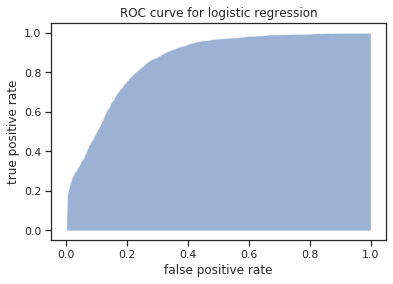

The area under the curve is 0.8661201459924599


In [29]:
#with this we get the score of the prediciton (not 0 or 1, but something in between). Usually if prediction is less
#than 0.5 then the event is classified as 0 and 1 otherwise.
scores = logistic.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test,scores)

#now, let's plot it!!

plt.clf() #clear plot
plt.title("ROC curve for logistic regression")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
#plt.plot(fpr,tpr,linewidth=2)
plt.fill_between(fpr,0,tpr, alpha = 0.55)
plt.show()


print("The area under the curve is {}".format(auc(fpr,tpr)))

Not nice... We have to do two things now. 

* Maybe our data is not linear and Logistic regression (a linear model) does not classify well.
* Data is unbalanced, we need to resample to get balanced data. First I'll try to do this.

### Data preparation

Let's check how unbalanced data is w.r.t the target variable and try to generate a new dataset of this

In [30]:
class_samples = df.groupby("class")["class"].agg("count")
print("Class samples for 0: {}".format(class_samples[0]))
print("Class samples for 1: {}".format(class_samples[1]))
print("Ratio {}".format(class_samples[1]/class_samples[0]))

Class samples for 0: 37155
Class samples for 1: 11687
Ratio 0.3145471672722379


In [31]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df.loc[df["class"] == 0,:]
df_minority = df.loc[df["class"] == 1,:]

n_samples = max([class_samples[0], class_samples[1]])

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=n_samples,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled["class"].value_counts()

1    37155
0    37155
Name: class, dtype: int64

In [32]:
df_ml = df_upsampled.copy()

#one hot encode the part we need
encoded = pd.get_dummies(df_ml.loc[:,categorical])
df_ml = pd.concat([df_ml.loc[:,numerical],encoded],axis = 1)
df_ml.head()

X_ = df_ml.copy()
y_ = df_upsampled[target]
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.33, random_state=1)

### Logistic Regression on balanced data

Running a simple logistic regression on the newly generated data

In [33]:
logistic = LogisticRegression(random_state=10)
logistic.fit(X_train_.values,y_train_.values.reshape(-1))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=10, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

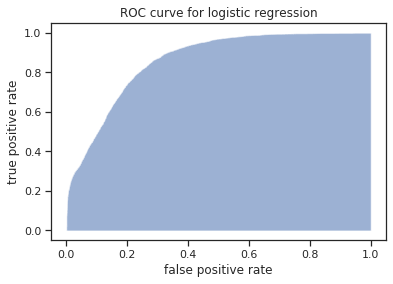

The area under the curve is 0.8621373243348751


In [34]:
#with this we get the score of the prediciton (not 0 or 1, but something in between). Usually if prediction is less
#than 0.5 then the event is classified as 0 and 1 otherwise.
scores = logistic.decision_function(X_test_)
fpr, tpr, _ = roc_curve(y_test_,scores)

#now, let's plot it!!

plt.clf() #clear plot
plt.title("ROC curve for logistic regression")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
#plt.plot(fpr,tpr,linewidth=2)
plt.fill_between(fpr,0,tpr, alpha = 0.55)
plt.show()


print("The area under the curve is {}".format(auc(fpr,tpr)))

Seems the result is even worse (I used a different random to split the data, if I change this random we find larger AUCs on the test set). So our initial thought that the problem was the unbalanced data seems to be wrong

### Feature selection

We will use greedy stepwise feature elimination. This is similar to stepwise elimination described in [the book](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf) page 207. The basic idea is to initially fit N models (being N the number of predictors) each one missing one variable and eliminate the predictor for which the model performed the worst. You do this several times until you get to the specified number of predictors.

In [35]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

n_predictors = 8

model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None)
selector = RFE(model, n_predictors, step=1)
selector = selector.fit(X_train.values, y_train.values)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
selected_features = X_train.loc[:,selector.support_].columns.values.tolist()
print("The {} variables that predict the best are: \n\n{}".format(n_predictors, ',\n'.join(selected_features)))

ranking = [feat for feat in selector.ranking_ if feat!=1]
ranking.sort()
ranking_low_to_high = X_train.iloc[:,ranking].columns.values.tolist()

print("\n\nRanking discarted features from low to high: \n\n{}".format(',\n'.join(ranking_low_to_high)))

The 8 variables that predict the best are: 

age,
capital-gain,
capital-loss,
hours-per-week,
marital-status_ Married-civ-spouse,
marital-status_ Never-married,
relationship_ Husband,
relationship_ Wife


Ranking discarted features from low to high: 

capital-loss,
hours-per-week,
marital-status_ Divorced,
marital-status_ Married-AF-spouse,
marital-status_ Married-civ-spouse,
marital-status_ Married-spouse-absent,
marital-status_ Never-married,
marital-status_ Separated,
marital-status_ Widowed,
relationship_ Husband,
relationship_ Not-in-family,
relationship_ Other-relative,
relationship_ Own-child,
relationship_ Unmarried,
relationship_ Wife,
race_ Amer-Indian-Eskimo


### Random Forest 

Let's now try a non linear classifier such as the random forest. Further so, well try to optimize the hiperparameters to find the optimum ones using grid search.

We define a cross validation of 3. That is, for every paramter trial, we train three times the same classifier but on 2/3 of the data and testing on the third part, then we test on the third part. The average of the three tests is the estimation of the error for a particular set of parameters. See [here](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) for further details.

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators':[50,100],
               'max_features': [2,3],
               'max_depth': [4,8,10],
               "criterion": ["gini", "entropy"]}]

grid_search = GridSearchCV(estimator = RandomForestClassifier(),
                           param_grid = param_grid,
                           cv = 3,
                           verbose = 5)

grid_search.fit(X_train.values,y_train.values.flatten())

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] criterion=gini, max_depth=4, max_features=2, n_estimators=50 ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=4, max_features=2, n_estimators=50, score=0.805, total=   0.3s
[CV] criterion=gini, max_depth=4, max_features=2, n_estimators=50 ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=2, n_estimators=50, score=0.801, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=2, n_estimators=50 ....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=2, n_estimators=50, score=0.798, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=2, n_estimators=100 ...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=2, n_estimators=100, score=0.802, total=   0.4s
[CV] criterion=gini, max_depth=4, max_features=2, n_estimators=100 ...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=2, n_estimators=100, score=0.801, total=   0.4s
[CV] criterion=gini, max_depth=4, max_features=2, n_estimators=100 ...
[CV]  criterion=gini, max_depth=4, max_features=2, n_estimators=100, score=0.800, total=   0.4s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=50 ....
[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=50, score=0.806, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=50 ....
[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=50, score=0.810, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=50 ....
[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=50, score=0.814, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=100 ...
[CV]  criterion=gini, max_depth=4, max_features=3, n_estimators=100, score=0.810, total=   0.5s
[CV] criterion=gini, max_depth=4, max_features=3, n_estimators=100 ...
[

[CV]  criterion=entropy, max_depth=8, max_features=2, n_estimators=100, score=0.817, total=   0.7s
[CV] criterion=entropy, max_depth=8, max_features=3, n_estimators=50 .
[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=50, score=0.819, total=   0.4s
[CV] criterion=entropy, max_depth=8, max_features=3, n_estimators=50 .
[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=50, score=0.820, total=   0.4s
[CV] criterion=entropy, max_depth=8, max_features=3, n_estimators=50 .
[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=50, score=0.820, total=   0.4s
[CV] criterion=entropy, max_depth=8, max_features=3, n_estimators=100 
[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=100, score=0.819, total=   0.7s
[CV] criterion=entropy, max_depth=8, max_features=3, n_estimators=100 
[CV]  criterion=entropy, max_depth=8, max_features=3, n_estimators=100, score=0.820, total=   0.8s
[CV] criterion=entropy, max_depth=8, max_features=3, n

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   32.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [38]:
print("Best parameters are: \n{}".format(grid_search.best_params_))

Best parameters are: 
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 3, 'n_estimators': 50}


Let's change the scores so that we can see recall, accuracy and auc.

In [39]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score

param_grid = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70],
               'max_features': [2,3],
               'max_depth': [10, 15, 20, 25, 30],
               "criterion": ["gini", "entropy"]}]

scorers = {
    #'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score)
}

I increased the paramters... this will take a while but makes sense from the previous results. Just more exploration can get us to the best result (possibly)

In [40]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, scoring=scorers, refit="auc",
                           cv=3, return_train_score=True, n_jobs=1,verbose = 5)
grid_search.fit(X_train.values, y_train.values.flatten())
results = grid_search.cv_results_

Fitting 3 folds for each of 140 candidates, totalling 420 fits
[CV] criterion=gini, max_depth=10, max_features=2, n_estimators=10 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=10, max_features=2, n_estimators=10, accuracy_score=(train=0.833, test=0.822), auc=(train=0.709, test=0.697), recall_score=(train=0.471, test=0.457), total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=2, n_estimators=10 ...
[CV]  criterion=gini, max_depth=10, max_features=2, n_estimators=10, accuracy_score=(train=0.825, test=0.820), auc=(train=0.639, test=0.630), recall_score=(train=0.279, test=0.264), total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=2, n_estimators=10 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=gini, max_depth=10, max_features=2, n_estimators=10, accuracy_score=(train=0.832, test=0.824), auc=(train=0.715, test=0.700), recall_score=(train=0.490, test=0.460), total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=2, n_estimators=20 ...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=10, max_features=2, n_estimators=20, accuracy_score=(train=0.825, test=0.820), auc=(train=0.639, test=0.633), recall_score=(train=0.280, test=0.272), total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=2, n_estimators=20 ...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV]  criterion=gini, max_depth=10, max_features=2, n_estimators=20, accuracy_score=(train=0.824, test=0.819), auc=(train=0.641, test=0.632), recall_score=(train=0.288, test=0.270), total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=2, n_estimators=20 ...
[CV]  criterion=gini, max_depth=10, max_features=2, n_estimators=20, accuracy_score=(train=0.835, test=0.826), auc=(train=0.700, test=0.686), recall_score=(train=0.440, test=0.414), total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=2, n_estimators=30 ...
[CV]  criterion=gini, max_depth=10, max_features=2, n_estimators=30, accuracy_score=(train=0.834, test=0.824), auc=(train=0.713, test=0.704), recall_score=(train=0.478, test=0.472), total=   0.2s
[CV] criterion=gini, max_depth=10, max_features=2, n_estimators=30 ...
[CV]  criterion=gini, max_depth=10, max_features=2, n_estimators=30, accuracy_score=(train=0.823, test=0.821), auc=(train=0.638, test=0.634), recall_score=(train=0.280, test=0.275), total=   0.3s
[CV

[CV]  criterion=gini, max_depth=10, max_features=3, n_estimators=50, accuracy_score=(train=0.837, test=0.826), auc=(train=0.715, test=0.696), recall_score=(train=0.478, test=0.445), total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=3, n_estimators=60 ...
[CV]  criterion=gini, max_depth=10, max_features=3, n_estimators=60, accuracy_score=(train=0.836, test=0.830), auc=(train=0.704, test=0.699), recall_score=(train=0.449, test=0.446), total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=3, n_estimators=60 ...
[CV]  criterion=gini, max_depth=10, max_features=3, n_estimators=60, accuracy_score=(train=0.825, test=0.822), auc=(train=0.641, test=0.637), recall_score=(train=0.286, test=0.279), total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=3, n_estimators=60 ...
[CV]  criterion=gini, max_depth=10, max_features=3, n_estimators=60, accuracy_score=(train=0.837, test=0.826), auc=(train=0.691, test=0.673), recall_score=(train=0.408, test=0.376), total=   0.5s
[CV

[CV]  criterion=gini, max_depth=15, max_features=3, n_estimators=20, accuracy_score=(train=0.853, test=0.828), auc=(train=0.747, test=0.712), recall_score=(train=0.542, test=0.489), total=   0.2s
[CV] criterion=gini, max_depth=15, max_features=3, n_estimators=20 ...
[CV]  criterion=gini, max_depth=15, max_features=3, n_estimators=20, accuracy_score=(train=0.854, test=0.832), auc=(train=0.741, test=0.704), recall_score=(train=0.523, test=0.458), total=   0.3s
[CV] criterion=gini, max_depth=15, max_features=3, n_estimators=20 ...
[CV]  criterion=gini, max_depth=15, max_features=3, n_estimators=20, accuracy_score=(train=0.856, test=0.828), auc=(train=0.749, test=0.708), recall_score=(train=0.544, test=0.477), total=   0.2s
[CV] criterion=gini, max_depth=15, max_features=3, n_estimators=30 ...
[CV]  criterion=gini, max_depth=15, max_features=3, n_estimators=30, accuracy_score=(train=0.853, test=0.828), auc=(train=0.749, test=0.717), recall_score=(train=0.548, test=0.503), total=   0.4s
[CV

[CV]  criterion=gini, max_depth=20, max_features=2, n_estimators=50, accuracy_score=(train=0.872, test=0.829), auc=(train=0.776, test=0.710), recall_score=(train=0.592, test=0.482), total=   0.6s
[CV] criterion=gini, max_depth=20, max_features=2, n_estimators=50 ...
[CV]  criterion=gini, max_depth=20, max_features=2, n_estimators=50, accuracy_score=(train=0.873, test=0.827), auc=(train=0.784, test=0.717), recall_score=(train=0.613, test=0.505), total=   0.6s
[CV] criterion=gini, max_depth=20, max_features=2, n_estimators=60 ...
[CV]  criterion=gini, max_depth=20, max_features=2, n_estimators=60, accuracy_score=(train=0.873, test=0.828), auc=(train=0.786, test=0.722), recall_score=(train=0.619, test=0.518), total=   0.7s
[CV] criterion=gini, max_depth=20, max_features=2, n_estimators=60 ...
[CV]  criterion=gini, max_depth=20, max_features=2, n_estimators=60, accuracy_score=(train=0.872, test=0.830), auc=(train=0.777, test=0.711), recall_score=(train=0.595, test=0.482), total=   0.7s
[CV

[CV]  criterion=gini, max_depth=25, max_features=2, n_estimators=10, accuracy_score=(train=0.878, test=0.818), auc=(train=0.792, test=0.708), recall_score=(train=0.627, test=0.497), total=   0.1s
[CV] criterion=gini, max_depth=25, max_features=2, n_estimators=20 ...
[CV]  criterion=gini, max_depth=25, max_features=2, n_estimators=20, accuracy_score=(train=0.883, test=0.820), auc=(train=0.799, test=0.708), recall_score=(train=0.636, test=0.493), total=   0.3s
[CV] criterion=gini, max_depth=25, max_features=2, n_estimators=20 ...
[CV]  criterion=gini, max_depth=25, max_features=2, n_estimators=20, accuracy_score=(train=0.881, test=0.823), auc=(train=0.797, test=0.711), recall_score=(train=0.635, test=0.496), total=   0.3s
[CV] criterion=gini, max_depth=25, max_features=2, n_estimators=20 ...
[CV]  criterion=gini, max_depth=25, max_features=2, n_estimators=20, accuracy_score=(train=0.881, test=0.817), auc=(train=0.797, test=0.706), recall_score=(train=0.635, test=0.493), total=   0.3s
[CV

[CV]  criterion=gini, max_depth=25, max_features=3, n_estimators=50, accuracy_score=(train=0.885, test=0.820), auc=(train=0.805, test=0.711), recall_score=(train=0.650, test=0.501), total=   0.7s
[CV] criterion=gini, max_depth=25, max_features=3, n_estimators=50 ...
[CV]  criterion=gini, max_depth=25, max_features=3, n_estimators=50, accuracy_score=(train=0.883, test=0.824), auc=(train=0.801, test=0.715), recall_score=(train=0.643, test=0.504), total=   0.7s
[CV] criterion=gini, max_depth=25, max_features=3, n_estimators=50 ...
[CV]  criterion=gini, max_depth=25, max_features=3, n_estimators=50, accuracy_score=(train=0.884, test=0.821), auc=(train=0.803, test=0.714), recall_score=(train=0.647, test=0.507), total=   0.7s
[CV] criterion=gini, max_depth=25, max_features=3, n_estimators=60 ...
[CV]  criterion=gini, max_depth=25, max_features=3, n_estimators=60, accuracy_score=(train=0.885, test=0.821), auc=(train=0.805, test=0.714), recall_score=(train=0.651, test=0.508), total=   0.8s
[CV

[CV]  criterion=gini, max_depth=30, max_features=3, n_estimators=10, accuracy_score=(train=0.880, test=0.816), auc=(train=0.792, test=0.697), recall_score=(train=0.620, test=0.468), total=   0.1s
[CV] criterion=gini, max_depth=30, max_features=3, n_estimators=10 ...
[CV]  criterion=gini, max_depth=30, max_features=3, n_estimators=10, accuracy_score=(train=0.881, test=0.815), auc=(train=0.796, test=0.705), recall_score=(train=0.633, test=0.493), total=   0.2s
[CV] criterion=gini, max_depth=30, max_features=3, n_estimators=20 ...
[CV]  criterion=gini, max_depth=30, max_features=3, n_estimators=20, accuracy_score=(train=0.886, test=0.820), auc=(train=0.806, test=0.712), recall_score=(train=0.652, test=0.503), total=   0.3s
[CV] criterion=gini, max_depth=30, max_features=3, n_estimators=20 ...
[CV]  criterion=gini, max_depth=30, max_features=3, n_estimators=20, accuracy_score=(train=0.883, test=0.819), auc=(train=0.803, test=0.707), recall_score=(train=0.648, test=0.489), total=   0.3s
[CV

[CV]  criterion=entropy, max_depth=10, max_features=2, n_estimators=40, accuracy_score=(train=0.835, test=0.827), auc=(train=0.708, test=0.691), recall_score=(train=0.463, test=0.430), total=   0.3s
[CV] criterion=entropy, max_depth=10, max_features=2, n_estimators=50 
[CV]  criterion=entropy, max_depth=10, max_features=2, n_estimators=50, accuracy_score=(train=0.825, test=0.821), auc=(train=0.639, test=0.634), recall_score=(train=0.280, test=0.272), total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=2, n_estimators=50 
[CV]  criterion=entropy, max_depth=10, max_features=2, n_estimators=50, accuracy_score=(train=0.822, test=0.820), auc=(train=0.636, test=0.633), recall_score=(train=0.276, test=0.272), total=   0.4s
[CV] criterion=entropy, max_depth=10, max_features=2, n_estimators=50 
[CV]  criterion=entropy, max_depth=10, max_features=2, n_estimators=50, accuracy_score=(train=0.835, test=0.829), auc=(train=0.690, test=0.680), recall_score=(train=0.411, test=0.392), total

[CV]  criterion=entropy, max_depth=15, max_features=2, n_estimators=10, accuracy_score=(train=0.848, test=0.830), auc=(train=0.741, test=0.713), recall_score=(train=0.533, test=0.487), total=   0.1s
[CV] criterion=entropy, max_depth=15, max_features=2, n_estimators=10 
[CV]  criterion=entropy, max_depth=15, max_features=2, n_estimators=10, accuracy_score=(train=0.846, test=0.826), auc=(train=0.733, test=0.701), recall_score=(train=0.514, test=0.459), total=   0.1s
[CV] criterion=entropy, max_depth=15, max_features=2, n_estimators=20 
[CV]  criterion=entropy, max_depth=15, max_features=2, n_estimators=20, accuracy_score=(train=0.851, test=0.831), auc=(train=0.745, test=0.717), recall_score=(train=0.538, test=0.497), total=   0.2s
[CV] criterion=entropy, max_depth=15, max_features=2, n_estimators=20 
[CV]  criterion=entropy, max_depth=15, max_features=2, n_estimators=20, accuracy_score=(train=0.850, test=0.828), auc=(train=0.729, test=0.695), recall_score=(train=0.496, test=0.438), total

[CV]  criterion=entropy, max_depth=15, max_features=3, n_estimators=40, accuracy_score=(train=0.851, test=0.828), auc=(train=0.747, test=0.712), recall_score=(train=0.547, test=0.486), total=   0.4s
[CV] criterion=entropy, max_depth=15, max_features=3, n_estimators=50 
[CV]  criterion=entropy, max_depth=15, max_features=3, n_estimators=50, accuracy_score=(train=0.851, test=0.831), auc=(train=0.737, test=0.711), recall_score=(train=0.518, test=0.480), total=   0.5s
[CV] criterion=entropy, max_depth=15, max_features=3, n_estimators=50 
[CV]  criterion=entropy, max_depth=15, max_features=3, n_estimators=50, accuracy_score=(train=0.851, test=0.832), auc=(train=0.736, test=0.705), recall_score=(train=0.513, test=0.459), total=   0.5s
[CV] criterion=entropy, max_depth=15, max_features=3, n_estimators=50 
[CV]  criterion=entropy, max_depth=15, max_features=3, n_estimators=50, accuracy_score=(train=0.851, test=0.827), auc=(train=0.742, test=0.705), recall_score=(train=0.532, test=0.471), total

[CV]  criterion=entropy, max_depth=20, max_features=3, n_estimators=10, accuracy_score=(train=0.866, test=0.825), auc=(train=0.773, test=0.717), recall_score=(train=0.594, test=0.507), total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=3, n_estimators=10 
[CV]  criterion=entropy, max_depth=20, max_features=3, n_estimators=10, accuracy_score=(train=0.867, test=0.825), auc=(train=0.776, test=0.714), recall_score=(train=0.599, test=0.498), total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=3, n_estimators=10 
[CV]  criterion=entropy, max_depth=20, max_features=3, n_estimators=10, accuracy_score=(train=0.866, test=0.825), auc=(train=0.775, test=0.717), recall_score=(train=0.600, test=0.510), total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=3, n_estimators=20 
[CV]  criterion=entropy, max_depth=20, max_features=3, n_estimators=20, accuracy_score=(train=0.866, test=0.829), auc=(train=0.776, test=0.723), recall_score=(train=0.601, test=0.517), total

[CV]  criterion=entropy, max_depth=25, max_features=2, n_estimators=40, accuracy_score=(train=0.881, test=0.825), auc=(train=0.796, test=0.711), recall_score=(train=0.631, test=0.491), total=   0.5s
[CV] criterion=entropy, max_depth=25, max_features=2, n_estimators=40 
[CV]  criterion=entropy, max_depth=25, max_features=2, n_estimators=40, accuracy_score=(train=0.882, test=0.820), auc=(train=0.798, test=0.711), recall_score=(train=0.637, test=0.501), total=   0.5s
[CV] criterion=entropy, max_depth=25, max_features=2, n_estimators=50 
[CV]  criterion=entropy, max_depth=25, max_features=2, n_estimators=50, accuracy_score=(train=0.882, test=0.822), auc=(train=0.801, test=0.714), recall_score=(train=0.643, test=0.506), total=   0.7s
[CV] criterion=entropy, max_depth=25, max_features=2, n_estimators=50 
[CV]  criterion=entropy, max_depth=25, max_features=2, n_estimators=50, accuracy_score=(train=0.881, test=0.826), auc=(train=0.796, test=0.712), recall_score=(train=0.633, test=0.492), total

[CV]  criterion=entropy, max_depth=25, max_features=3, n_estimators=70, accuracy_score=(train=0.882, test=0.822), auc=(train=0.803, test=0.719), recall_score=(train=0.652, test=0.520), total=   1.0s
[CV] criterion=entropy, max_depth=30, max_features=2, n_estimators=10 
[CV]  criterion=entropy, max_depth=30, max_features=2, n_estimators=10, accuracy_score=(train=0.882, test=0.816), auc=(train=0.801, test=0.707), recall_score=(train=0.645, test=0.494), total=   0.2s
[CV] criterion=entropy, max_depth=30, max_features=2, n_estimators=10 
[CV]  criterion=entropy, max_depth=30, max_features=2, n_estimators=10, accuracy_score=(train=0.880, test=0.818), auc=(train=0.794, test=0.701), recall_score=(train=0.628, test=0.475), total=   0.2s
[CV] criterion=entropy, max_depth=30, max_features=2, n_estimators=10 
[CV]  criterion=entropy, max_depth=30, max_features=2, n_estimators=10, accuracy_score=(train=0.881, test=0.815), auc=(train=0.801, test=0.709), recall_score=(train=0.646, test=0.503), total

[CV]  criterion=entropy, max_depth=30, max_features=3, n_estimators=40, accuracy_score=(train=0.886, test=0.819), auc=(train=0.809, test=0.712), recall_score=(train=0.659, test=0.505), total=   3.9s
[CV] criterion=entropy, max_depth=30, max_features=3, n_estimators=40 
[CV]  criterion=entropy, max_depth=30, max_features=3, n_estimators=40, accuracy_score=(train=0.885, test=0.819), auc=(train=0.807, test=0.709), recall_score=(train=0.657, test=0.495), total=   3.9s
[CV] criterion=entropy, max_depth=30, max_features=3, n_estimators=40 
[CV]  criterion=entropy, max_depth=30, max_features=3, n_estimators=40, accuracy_score=(train=0.885, test=0.816), auc=(train=0.807, test=0.710), recall_score=(train=0.656, test=0.505), total=   5.8s
[CV] criterion=entropy, max_depth=30, max_features=3, n_estimators=50 
[CV]  criterion=entropy, max_depth=30, max_features=3, n_estimators=50, accuracy_score=(train=0.887, test=0.817), auc=(train=0.808, test=0.708), recall_score=(train=0.655, test=0.498), total

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 44.1min finished


These are the best parameters found

In [41]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 20, 'max_features': 3, 'n_estimators': 30}

In [42]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
# I want the program to plot with this parameters, all of them must be in the dict specified
params = {'criterion':['entropy'], 'max_depth':[10, 15, 20, 25, 30], 'max_features':[3]}
# and x axis this
x_axis_param = 'n_estimators'

#from itertools import product
import itertools
def filter_per_params(params, x_axis_param, results):
    vals = list(params.values())
    param_comb = list(itertools.product(*vals))
    keys = list(params.keys())
    
    
    indices = []
    for i, param_set in enumerate(param_comb):
        #all indices
        idx = list(range(len(results['param_' + keys[0]])))
        for j, param in enumerate(param_set):
            p = results['param_' + keys[j]]
            idx = [k for k in idx if p[k] == param]
        indices.append(idx)
            
    return param_comb, indices
        
to_plot = filter_per_params(params, x_axis_param, results)

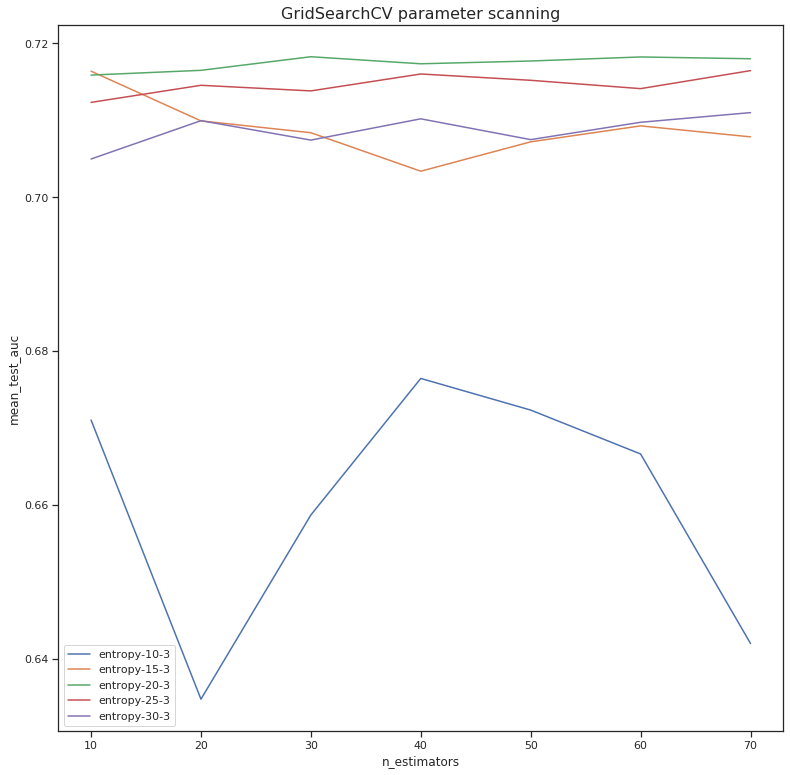

In [44]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV parameter scanning",
          fontsize=16)

y_label = 'mean_test_auc'
plt.xlabel(x_axis_param)
plt.ylabel(y_label)

ax = plt.gca()
#ax.set_xlim(0, 402)
#ax.set_ylim(0.86, 0.9)

idx = to_plot[1][1]
X_axis = np.array(results['param_' + x_axis_param][idx], dtype=float)

for param, idx in zip(to_plot[0], to_plot[1]):
    param = '-'.join([str(p) for p in param])
    ax.plot(X_axis, results[y_label][idx], alpha=1, label="%s" % (param))
    
plt.legend(loc='best')
plt.show()

In this last plot we can see that the best classifier w.r.t AUC is with number of estimators 60, criterion being entropy, maximum depth 20 and 3 random variables per split to choose.

Won't go deep on the function I programmed before but it is susper useful for compraison on grid_search. I will keep it to use it in other examples. I just want to show you here the quantity of information contained in results parameter (results = grid_search.cv_results_)

In [45]:
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_recall_score', 'split1_test_recall_score', 'split2_test_recall_score', 'mean_test_recall_score', 'std_test_recall_score', 'rank_test_recall_score', 'split0_train_recall_score', 'split1_train_recall_score', 'split2_train_recall_score', 'mean_train_recall_score', 'std_train_recall_score', 'split0_test_accuracy_score', 'split1_test_accuracy_score', 'split2_test_accuracy_score', 'mean_test_accuracy_score', 'std_test_accuracy_score', 'rank_test_accuracy_score', 'split0_train_accuracy_score', 'split1_train_accuracy_score', 'split2_train_accuracy_score', 'mean_train_accuracy_score', 'std_train_accuracy_score', 'split0_test_auc', 'split1_test_auc', 'split2_test_auc', 'mean_test_auc', 'std_test_auc', 'rank_test_auc', 'split0_train_auc', 'split1_train_auc', 'split2_train_auc', 'mean_train_auc', 'std_train_auc'])

Getting back to topic, AUC in this case is even worse compared to logistic regression. Maybe the data is quite linear so logistic regression works well.